In [1]:
!pip install -r requirements.txt

In [2]:
!python --version


Python 3.7.1


# Importing libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import learning_curve, cross_val_score, train_test_split, cross_val_predict, StratifiedKFold, cross_validate, GridSearchCV, ShuffleSplit
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score, average_precision_score, roc_curve, accuracy_score, make_scorer, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, precision_recall_curve,average_precision_score, auc,f1_score, make_scorer, recall_score, accuracy_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, brier_score_loss,log_loss
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import time
import itertools
import timeit
import gc


# Understanding Data and objective 

## Objective: Churn is a one of the biggest problem in the telecom industry. We will be looking into this data and finding patters which cause churn. 


> This will help in reaching folks proactively who are going to churn and extend them an offer if they are valuable to the company.

## loading data

In [4]:
df_churn = pd.read_csv('data/Telecom_customer_churn.csv', index_col = False)
print(df_churn.dtypes)
print(f'unique Value of our Target_class:  {df_churn.Churn.unique()}')

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
unique Value of our Target_class:  ['No' 'Yes']


**We have Customer_id which  will be unique to a user and rest mix of numeric and catgorical** 

## Basic EDA 

In [5]:
# converting total_charges to numeric

In [7]:
df_churn.TotalCharges = pd.to_numeric(df_churn.TotalCharges, errors='coerce')
df_churn.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [9]:
#Removing missing values 
df_churn.dropna(inplace = True)
#Remove customer IDs from the data set
df2 = df_churn.iloc[:,1:]
#Convertin the predictor variable in a binary numeric variable
df2['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df2['Churn'].replace(to_replace='No',  value=0, inplace=True)

In [10]:
#Let's convert all the categorical variables into dummy variables

In [11]:
#Let's convert all the categorical variables into dummy variables
df_dummies = pd.get_dummies(df2)
df_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


**There are around 450K observations with 25 columns with non-null values**

0    73.421502
1    26.578498
Name: Churn, dtype: float64


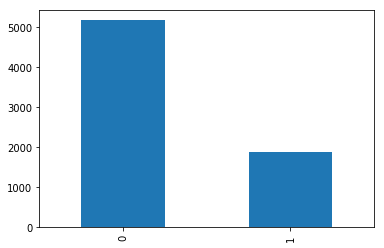

In [12]:
print( df_dummies['Churn'].value_counts()*100.0 /len( df_dummies))
df_dummies['Churn'].value_counts().plot(kind='bar')


#### Out of all customers ~27% of total population churned. This is class imbalance problem andimportant to keep in mind for our modelling as skeweness could lead to a lot of false negatives.

In [36]:
# cooreation between two classes 

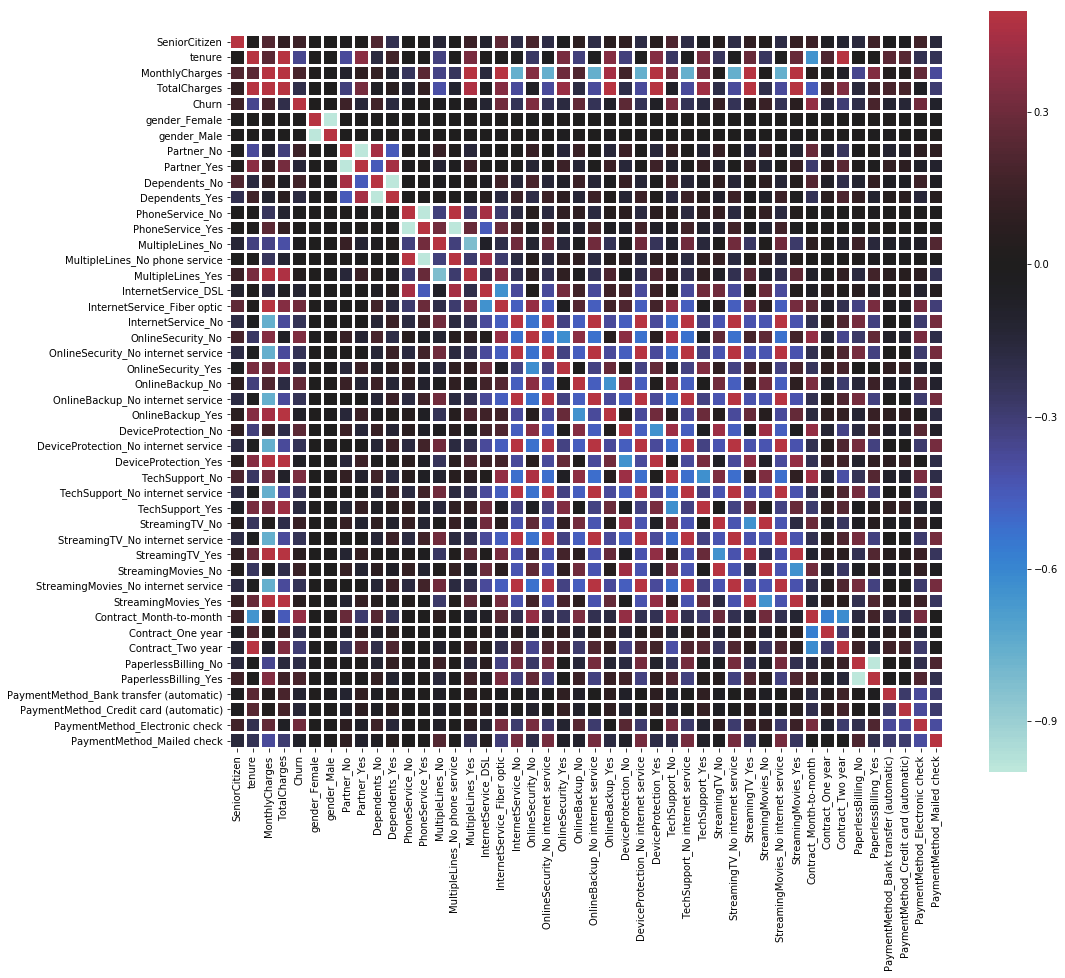

In [13]:
corr = df_dummies.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(corr, vmax=0.5, center=0,
            square=True, linewidths=2)
plt.show()

## Lets focus on Ordered column as we have some strong coorleated variables 

In [14]:
#Correlation with output variable
cor_target = abs(df_dummies.corr()['Churn'])
print(cor_target)


SeniorCitizen                              0.150541
tenure                                     0.354049
MonthlyCharges                             0.192858
TotalCharges                               0.199484
Churn                                      1.000000
gender_Female                              0.008545
gender_Male                                0.008545
Partner_No                                 0.149982
Partner_Yes                                0.149982
Dependents_No                              0.163128
Dependents_Yes                             0.163128
PhoneService_No                            0.011691
PhoneService_Yes                           0.011691
MultipleLines_No                           0.032654
MultipleLines_No phone service             0.011691
MultipleLines_Yes                          0.040033
InternetService_DSL                        0.124141
InternetService_Fiber optic                0.307463
InternetService_No                         0.227578
OnlineSecuri

#### We can see not very strong co-realtion with all orders somein low value, its better to reduce this dataset to build our first model. 

> users who checked out the delivery options on a product detail page have an almost 80% correlation to orders,

# Finding relevant columns with Correaltion over 20% 

In [16]:
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]
relevant_features

tenure                                  0.354049
Churn                                   1.000000
InternetService_Fiber optic             0.307463
InternetService_No                      0.227578
OnlineSecurity_No                       0.342235
OnlineSecurity_No internet service      0.227578
OnlineBackup_No                         0.267595
OnlineBackup_No internet service        0.227578
DeviceProtection_No                     0.252056
DeviceProtection_No internet service    0.227578
TechSupport_No                          0.336877
TechSupport_No internet service         0.227578
StreamingTV_No internet service         0.227578
StreamingMovies_No internet service     0.227578
Contract_Month-to-month                 0.404565
Contract_Two year                       0.301552
PaymentMethod_Electronic check          0.301455
Name: Churn, dtype: float64

In [17]:
df_dummies.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'gender_Female', 'gender_Male', 'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two

# creating relevant prediction list

In [22]:
predictors_list = ['tenure','InternetService_Fiber optic', 'InternetService_No', 'PaymentMethod_Electronic check',
       'OnlineSecurity_No', 'OnlineBackup_No', 'OnlineBackup_No internet service',  'StreamingTV_No internet service',
       'OnlineSecurity_No internet service','DeviceProtection_No','StreamingMovies_No internet service',
       'DeviceProtection_No internet service','TechSupport_No', 'TechSupport_No internet service','Contract_Two year','Contract_Month-to-month']


#### deleting orginal dataset and use Undersampled data to accound for class imbalance 

In [19]:
del df_churn
gc.collect()

8432

# creating helper functions

In [23]:
def split_data(df,feature_ls, y_target, training: bool = False) -> None:
        """
        Split the data into train, test for model building
        
        returns the Test and train data
        """
        if training:
            df = df.sample(frac=1)
            X_train, X_test, y_train,y_test = train_test_split(df[feature_ls], df[y_target], test_size=0.2, random_state=123) 
            print(X_train.shape,X_test.shape)
            #changing object datatype to int 
            return X_train, X_test, y_train,y_test
        
def get_and_save_metrics(true_labels, pred_labels, y_scores):
    """
    Using Sklearn Metrics, returns dataframe of all the relevant evaluation metrics
    for binary classification. 
    """
    
    accuracy = accuracy_score(true_labels, pred_labels)
    tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()
    precision_1 = precision_score(true_labels, pred_labels, pos_label=1)
    precision_0 = precision_score(true_labels, pred_labels, pos_label=0)
    recall_1 = recall_score(true_labels, pred_labels, pos_label=1)
    recall_0 = recall_score(true_labels, pred_labels, pos_label=0)
    f1_score_1 = f1_score(true_labels, pred_labels, pos_label=1)

    f1_score_0 = f1_score(true_labels, pred_labels, pos_label=0)
    auc_score = roc_auc_score(true_labels, y_scores)
    metrics = [[accuracy, tn, tp, fn, fp, precision_1, precision_0, recall_1, recall_0, f1_score_1, f1_score_0, auc_score]]
    metrics_df = pd.DataFrame(metrics)
    metrics_df.columns = ['accuracy', 'true_negative', 'true_positive', 'false_negative', 'false_positive',
                          'precision_class_1', 'precision_class_0', 'recall_class_1', 'recall_class_0',
                          'f1_score_class_1', 'f1_score_class_0', 'roc_auc_score']
    return metrics_df


def learning_curve(estimator, X, y, title = "Learning curve"):
    """
    Plotting learning curve by running 3 fold cross validation
    we will be using f-1 score as we have seen there is class imbalance 
    """
    
    f1_train_mean = []
    f1_train_std = []  
    cv_mean = []
    cv_std = []  
    fit_mean = []
    fit_std = []  
    pred_mean = []
    pred_std = []  

    data_size_list = (np.linspace(.05, 1.0, 20) * len(y)).astype('int')

    for len_data in data_size_list:
        index = np.random.randint(X.shape[0], size=len_data)
        sampl_train_data = X.iloc[index, :]
        sampl_train_label = y.iloc[index]
        scores = cross_validate(estimator, sampl_train_data, sampl_train_label, cv=3, scoring='f1', n_jobs=-1, return_train_score=True)

        f1_train_mean.append(np.mean(scores['train_score']))
        f1_train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score']))
        cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time']))
        fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time']))
        pred_std.append(np.std(scores['score_time']))

    f1_train_mean = np.array(f1_train_mean);
    f1_train_std = np.array(f1_train_std)
    cv_mean = np.array(cv_mean);
    cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean);
    fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean);
    pred_std = np.array(pred_std)
    
    
    # plotting Learning curve 
    plt.figure()
    plt.title("Learning curve : " + title)
    plt.xlabel("Training size")
    plt.ylabel("F1 Score")
    plt.fill_between(data_size_list, f1_train_mean - 2 * f1_train_std, f1_train_mean + 2 * f1_train_std, alpha=0.1)
    plt.fill_between(data_size_list, cv_mean - 2 * cv_std, cv_mean + 2 * cv_std, alpha=0.1)
    plt.plot(data_size_list, f1_train_mean, 'o-', label="Training Score")
    plt.plot(data_size_list, cv_mean, 'o-',label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.show()
    
    # plotting time 
    plt.figure()
    plt.title("Time taken by classifier: " + title)
    plt.xlabel("Training size")
    plt.ylabel("Time  in (s)")
    plt.fill_between(data_size_list, fit_mean - 2 * fit_std, fit_mean + 2 * fit_std, alpha=0.1)
    plt.fill_between(data_size_list, pred_mean - 2 * pred_std, pred_mean + 2 * pred_std, alpha=0.1)
    plt.plot(data_size_list, fit_mean, 'o-',  label="Training Time  in (s)")
    plt.plot(data_size_list, pred_std, 'o-', label="Prediction Time in (s)")
    plt.legend(loc="best")
    plt.show()


    # plot_times(data_size_list, fit_mean, fit_std, pred_mean, pred_std, title)

    return f1_train_mean, fit_mean, pred_mean

def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

# fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
# print(auc(fpr, tpr)) # AUC of ROC
# plot_roc_curve(fpr, tpr, 'precision_optimized')

In [24]:
X_train, X_test, y_train, y_test = split_data(df=df_dummies,feature_ls=predictors_list, y_target='Churn',training= True)



(5625, 16) (1407, 16)


### Neural Network 

# Neural Network Model complexity based on hidden layer size 

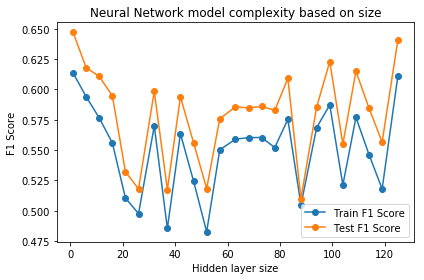

In [25]:
# neural Network Model complexity based on hidden layer size 

f1_score_test = []
f1_score_train = []
h_size = np.linspace(1,125,25).astype('int')
for size in h_size :         
        model = MLPClassifier(hidden_layer_sizes=(size,), solver='adam', activation='logistic', 
                            learning_rate_init=0.05, random_state=100)
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        f1_score_train.append(f1_score(y_train, y_pred_train))
        f1_score_test.append(f1_score(y_test, y_pred_test))
        
# plotting model complexity 
plt.plot(h_size, f1_score_train,'o-', label='Train F1 Score')
plt.plot(h_size, f1_score_test, 'o-', label='Test F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Hidden layer size')
plt.title('Neural Network model complexity based on size')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# getting best hyperparameters

In [26]:
def hp_search_nn(X_train, y_train):
    h_units = [5, 10, 20, 30, 40, 50, 60, 75, 100]
    learning_rates = [0.01, 0.05, .1]
    param_space = {'hidden_layer_sizes': h_units, 'learning_rate_init': learning_rates}

    model_nn = GridSearchCV(estimator = MLPClassifier(solver='adam',activation='logistic',random_state=123),
                       param_grid=param_space, cv=3)
    model_nn.fit(X_train, y_train)
    print("best Hyperrameters after 3 fold cv in grid search:")
    print(model_nn.best_params_)
    return model_nn.best_params_['hidden_layer_sizes'], model_nn.best_params_['learning_rate_init']

In [27]:
hl_size, alpha = hp_search_nn(X_train, y_train)

best Hyperrameters after 3 fold cv in grid search:
{'hidden_layer_sizes': 60, 'learning_rate_init': 0.01}


In [28]:
#Training and model metrics using 

In [29]:
# best neural Network 
model_nn = MLPClassifier(hidden_layer_sizes=(hl_size,), solver='adam', activation='logistic', 
                               learning_rate_init=alpha, random_state=123)
# getting evaluation metric on y_test 

start_time = timeit.default_timer()
model_nn.fit(X_train, y_train)
end_time = timeit.default_timer()

print(f"training_time to fit the model: {end_time - start_time}")    
start_time = timeit.default_timer()    
preds = model_nn.predict(X_test)
y_scores = model_nn.predict_proba(X_test)[:,1]
print(f"Time to score the test data: {end_time - start_time}")  



training_time to fit the model: 0.5079542999999376
Time to score the test data: -0.00018091200013259368


In [30]:
# model metrics
get_and_save_metrics(y_test, preds, y_scores)

,accuracy,true_negative,true_positive,false_negative,false_positive,precision_class_1,precision_class_0,recall_class_1,recall_class_0,f1_score_class_1,f1_score_class_0,roc_auc_score
0,0.804549,910,222,156,119,0.651026,0.853659,0.587302,0.884354,0.617524,0.868735,0.853723


**On data we have very high AUC socre along with good f1 score** 

0.8537234999820034


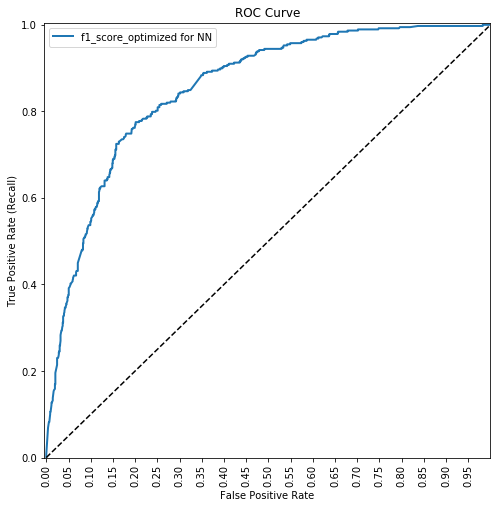

In [31]:
# getting ROC_curve 
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'f1_score_optimized for NN')

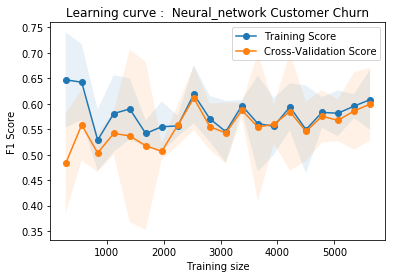

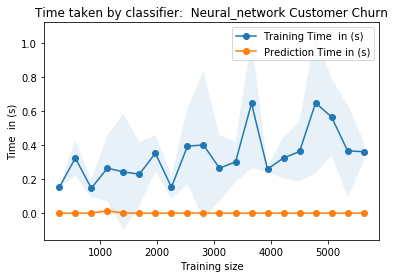

In [57]:
# ploting learning curve and time 
model_nn_train,model_nn_fit_time, model_nn_pred_time = learning_curve(model_nn, X_train, y_train, title= "Neural_network Customer Churn")

# Support vector Machines(SVM)


### Model complexity based on kernel function: linear, polynomial, rbf (radial basis function) 

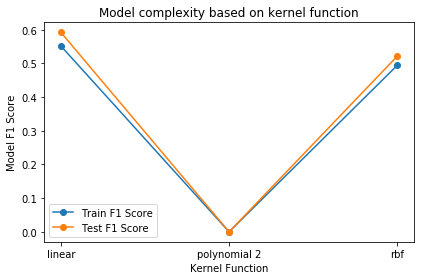

In [32]:
f1_score_test = []
f1_score_train = []
kernel_list = ['linear','poly','rbf']
for kernel in kernel_list:         
        if kernel == 'poly':
            svm_model = SVC(kernel=kernel, degree=2,random_state=123)
            svm_model.fit(X_train, y_train)
            y_pred_train = svm_model.predict(X_train)
            y_pred_test = svm_model.predict(X_test)
            f1_score_train.append(f1_score(y_train, y_pred_train))
            f1_score_test.append(f1_score(y_test, y_pred_test))
        else:    
            svm_model = SVC(kernel=kernel, random_state=123)
            svm_model.fit(X_train, y_train)
            y_pred_test = svm_model.predict(X_test)
            y_pred_train = svm_model.predict(X_train)
            f1_score_train.append(f1_score(y_train, y_pred_train))
            f1_score_test.append(f1_score(y_test, y_pred_test))
            

kernel_type = ['linear','polynomial 2','rbf']
plt.plot(kernel_type, f1_score_train, 'o-',  label='Train F1 Score')
plt.plot(kernel_type, f1_score_test, 'o-', label='Test F1 Score')
plt.ylabel('Model F1 Score')
plt.xlabel('Kernel Function')
plt.title('Model complexity based on kernel function')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# RBF kernel seems to work best so lets use as base SVM and do HP tunning 

In [33]:
def svm_hp_search(X_train, y_train):
    c = [1e-4, 1e-3, 1e-2, 1e01, 1]
    gamma = [1,10,100]
    param_space = {'C': c, 'gamma': gamma}

    svm_model = GridSearchCV(estimator = SVC(kernel='rbf',random_state=123),
                       param_grid=param_space, cv=3)
    svm_model.fit(X_train, y_train)
    print(" best parameters are:")
    print(svm_model.best_params_)
    return svm_model.best_params_['C'], svm_model.best_params_['gamma']

In [34]:
c_value, gamma = svm_hp_search(X_train, y_train)

 best parameters are:
{'C': 1, 'gamma': 1}


In [35]:
model_svm = SVC(C=c_value, gamma=gamma, kernel='rbf')
# getting evaluation metric on y_test 

start_time = timeit.default_timer()
model_svm.fit(X_train, y_train)
end_time = timeit.default_timer()

print(f"training_time to fit the model: {end_time - start_time}")    
start_time = timeit.default_timer()    
preds = model_svm.predict(X_test)

print(f"Time to score the test data: {end_time - start_time}")  



training_time to fit the model: 1.1173341149999487
Time to score the test data: -0.00015745700011393637


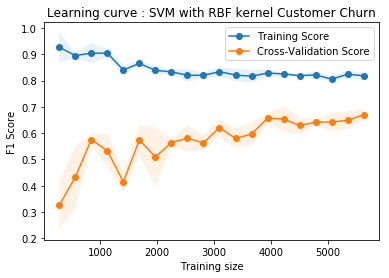

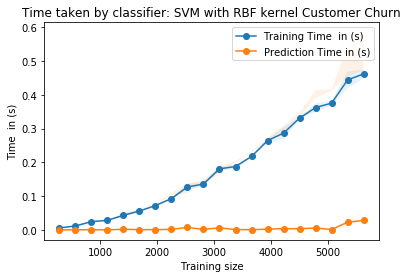

In [36]:
# ploting learning curve and time 
model_svm_train,model_svm_fit_time, model_svm_pred_time = learning_curve(model_svm, X_train, y_train, title= "SVM with RBF kernel Customer Churn")

# KNN Classifier

> We will only find right Hyperparameter n_neighbours 

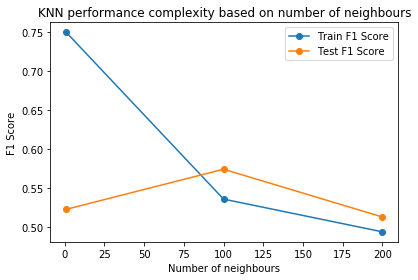

In [37]:
f1_score_test = []
f1_score_train = []
neigh_size = np.linspace(1,200,3).astype('int')
for size in neigh_size :         
        model = kNN(n_neighbors=size,n_jobs=-1)
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        f1_score_train.append(f1_score(y_train, y_pred_train))
        f1_score_test.append(f1_score(y_test, y_pred_test))
        
# plotting model complexity 
plt.plot(neigh_size, f1_score_train,'o-', label='Train F1 Score')
plt.plot(neigh_size, f1_score_test, 'o-', label='Test F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Number of neighbours')
plt.title('KNN performance complexity based on number of neighbours')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [38]:
#model prediction using KNN 

model_knn = kNN(n_neighbors=3, n_jobs=-1)
# getting evaluation metric on y_test 

start_time = timeit.default_timer()
model_knn.fit(X_train, y_train)
end_time = timeit.default_timer()

print(f"training_time to fit the model: {end_time - start_time}")    
start_time = timeit.default_timer()    
preds = model_knn.predict(X_test)
print(f"Time to score the test data: {end_time - start_time}")  



training_time to fit the model: 0.006730728000093222
Time to score the test data: -0.013799108000057458


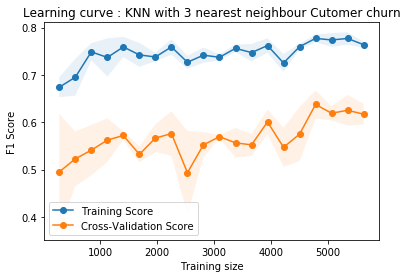

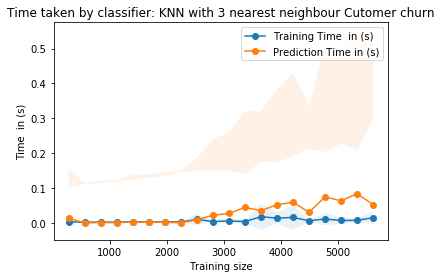

In [40]:
# ploting learning curve and time 
model_knn_train,model_knn_fit_time, model_knn_pred_time = learning_curve(model_knn, X_train, y_train, title= "KNN with 3 nearest neighbour Cutomer churn")

# Decision_Tree

### doing puining by setting max_depth parameter 

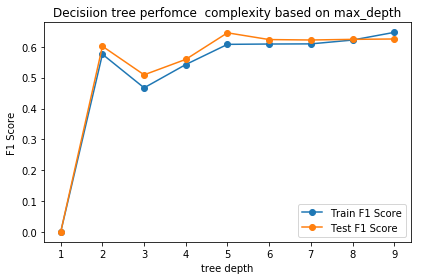

In [41]:
f1_score_test = []
f1_score_train = []
tree_depth = list(range(1,10))
for sp in tree_depth:         
        model = DecisionTreeClassifier(max_depth=sp, min_samples_leaf=1, criterion='entropy')
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        f1_score_train.append(f1_score(y_train, y_pred_train))
        f1_score_test.append(f1_score(y_test, y_pred_test))
        
# plotting model complexity 
plt.plot(tree_depth, f1_score_train,'o-', label='Train F1 Score')
plt.plot(tree_depth, f1_score_test, 'o-', label='Test F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('tree depth')
plt.title('Decisiion tree perfomce  complexity based on max_depth')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# search CV 


In [42]:
def dt_hp_search(X_train, y_train):
    param_space = {'min_samples_leaf':np.linspace(round(0.005*len(X_train)), round(0.05*len(X_train)),20).round().astype('int'), 'max_depth':np.arange(1,10)}

    model_dt = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid=param_space, cv=3)
    model_dt.fit(X_train, y_train)
    print("best parameters are:")
    print(model_dt.best_params_)
    return model_dt.best_params_['max_depth'], model_dt.best_params_['min_samples_leaf']

In [43]:
max_depth, min_leaf = dt_hp_search(X_train,y_train)
model_dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_leaf, criterion='entropy')

best parameters are:
{'max_depth': 7, 'min_samples_leaf': 41}


In [44]:
start_time = timeit.default_timer()
model_dt.fit(X_train, y_train)
end_time = timeit.default_timer()

print(f"training_time to fit the model: {end_time - start_time}")    
start_time = timeit.default_timer()    
preds = model_dt.predict(X_test)
y_scores = model_dt.predict_proba(X_test)[:,1]
print(f"Time to score the test data: {end_time - start_time}")  



training_time to fit the model: 0.008632730999806881
Time to score the test data: -0.00023753700020279211


In [45]:
# model metrics
get_and_save_metrics(y_test, preds, y_scores)

,accuracy,true_negative,true_positive,false_negative,false_positive,precision_class_1,precision_class_0,recall_class_1,recall_class_0,f1_score_class_1,f1_score_class_0,roc_auc_score
0,0.807392,924,212,166,105,0.66877,0.847706,0.560847,0.897959,0.610072,0.872109,0.850534


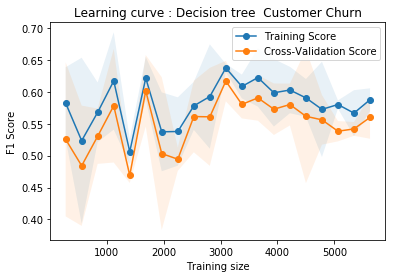

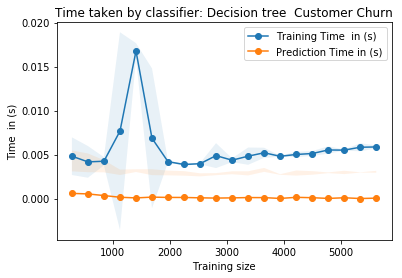

In [46]:
# ploting learning curve and time 
model_dt_train,model_dt_fit_time, model_dt_pred_time = learning_curve(model_dt, X_train, y_train, title= "Decision tree  Customer Churn")

0.850534242419568


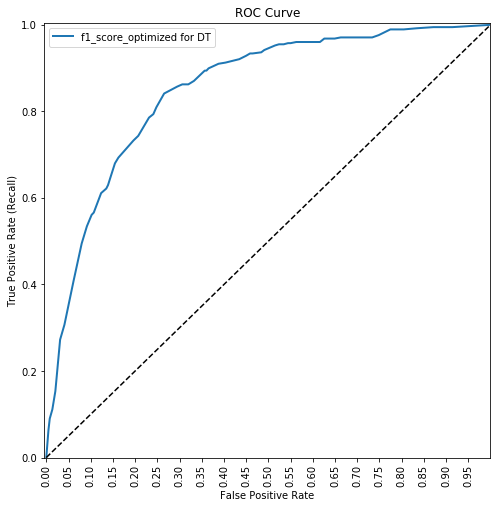

In [47]:
# getting ROC_curve 
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'f1_score_optimized for DT')

# Gradient Boosting
## Hyperparamter training 


In [48]:
def gbt_hp_search( X_train, y_train):

    param_space = {'min_samples_leaf':np.linspace(round(0.005*len(X_train)), round(0.05*len(X_train)),20).round().astype('int'),
                  'max_depth': list(range(1,5)),
                  'n_estimators': np.linspace(10,200,20).round().astype('int'),
                  'learning_rate': [.001,0.05, 0.1]}

    model_gbt = GridSearchCV(estimator = GradientBoostingClassifier(), param_grid=param_space, cv=3)
    model_gbt.fit(X_train, y_train)
    print("Best parameters are:")
    print(model_gbt.best_params_)
    return model_gbt.best_params_['max_depth'],model_gbt.best_params_['min_samples_leaf'], model_gbt.best_params_['n_estimators'],model_gbt.best_params_['learning_rate']

In [49]:
max_depth, min_leaf, n_est, alpha= gbt_hp_search(X_train,y_train)

Best parameters are:
{'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 201, 'n_estimators': 80}


In [50]:
model_gbt = GradientBoostingClassifier(max_depth=max_depth, min_samples_leaf=min_leaf, 
                                              n_estimators=n_est, learning_rate=alpha)

In [51]:
start_time = timeit.default_timer()
model_gbt.fit(X_train, y_train)
end_time = timeit.default_timer()

print(f"training_time to fit the model: {end_time - start_time}")    
start_time = timeit.default_timer()    
preds = model_gbt.predict(X_test)
y_scores = model_dt.predict_proba(X_test)[:,1]
print(f"Time to score the test data: {end_time - start_time}")  



training_time to fit the model: 0.29937260699989565
Time to score the test data: -0.0001797619997887523


In [52]:
# model metrics
get_and_save_metrics(y_test, preds, y_scores)

,accuracy,true_negative,true_positive,false_negative,false_positive,precision_class_1,precision_class_0,recall_class_1,recall_class_0,f1_score_class_1,f1_score_class_0,roc_auc_score
0,0.803127,912,218,160,117,0.650746,0.850746,0.57672,0.886297,0.611501,0.868158,0.850534


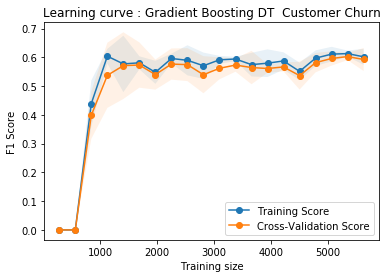

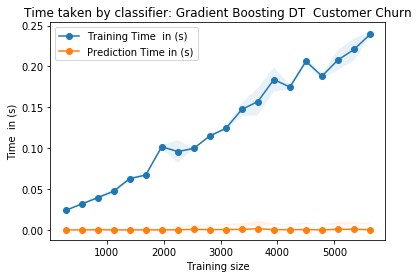

In [64]:
# ploting learning curve and time 
model_gbt_train,model_gbt_fit_time, model_gbt_pred_time = learning_curve(model_gbt, X_train, y_train, title= "Gradient Boosting DT  Customer Churn")

# model comparison metrics 

1. Model fitting Time

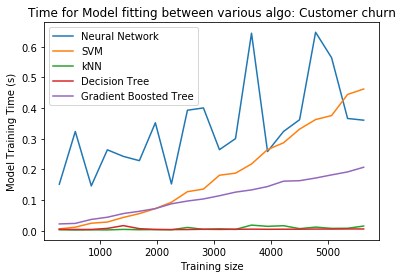

In [63]:
data_size = (np.linspace(.05, 1.0, 20) * len(y_train)).astype('int')
plt.figure()
plt.title("Time for Model fitting between various algo: Customer churn")
plt.xlabel("Training size")
plt.ylabel("Model Training Time (s)")
plt.plot(data_size, model_nn_fit_time, '-', label="Neural Network")
plt.plot(data_size, model_svm_fit_time, '-', label="SVM")
plt.plot(data_size, model_knn_fit_time, '-', label="kNN")
plt.plot(data_size, model_dt_fit_time, '-', label="Decision Tree")
plt.plot(data_size, model_gbt_fit_time, '-', label="Gradient Boosted Tree")
plt.legend(loc="best")
plt.show()

2. Model Inference time

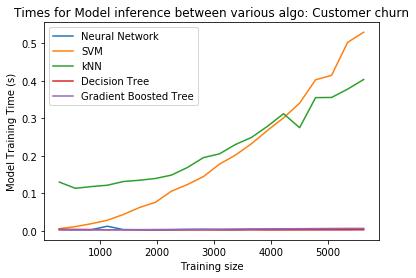

In [62]:
plt.figure()
plt.title("Times for Model inference between various algo: Customer churn")
plt.xlabel("Training size")
plt.ylabel("Model Training Time (s)")
plt.plot(data_size, model_nn_pred_time, '-', label="Neural Network")
plt.plot(data_size, model_svm_pred_time, '-', label="SVM")
plt.plot(data_size, model_knn_pred_time, '-', label="kNN")
plt.plot(data_size, model_dt_pred_time, '-', label="Decision Tree")
plt.plot(data_size, model_gbt_pred_time, '-', label="Gradient Boosted Tree")
plt.legend(loc="best")
plt.show()

3. Model performance velaution 

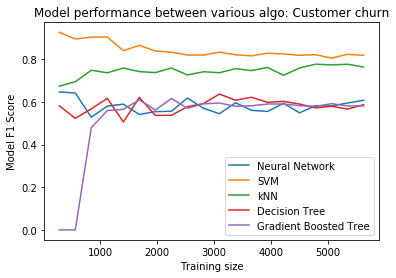

In [61]:

plt.figure()
plt.title("Model performance between various algo: Customer churn")
plt.xlabel("Training size")
plt.ylabel("Model F1 Score")
plt.plot(data_size, model_nn_train, '-', label="Neural Network")
plt.plot(data_size, model_svm_train, '-', label="SVM")
plt.plot(data_size, model_knn_train, '-', label="kNN")
plt.plot(data_size, model_dt_train, '-', label="Decision Tree")
plt.plot(data_size, model_gbt_train, '-', label="Gradient Boosted Tree")
plt.legend(loc="best")
plt.show()